# Exploring Partial Least Squares Regression
*From geeksforgeeks.org: https://www.geeksforgeeks.org/partial-least-squares-regression-plsregression-using-sklearn/*

*Instead of identifying hyperplanes of maximum variance between the response and independent variables, PLS regression constructs a linear regression model by projecting both the predicted and observable variables into a new space. This characteristic of projecting data to new spaces classifies PLS methods as bilinear factor models.*

*PLS is employed to uncover the underlying relationships between two matrices (X and Y). It takes a latent variable approach to model the covariance structures in these matrices. The objective of a PLS model is to identify a multidimensional direction in the X space that explains the maximum multidimensional variance direction in the Y space. PLS regression is particularly advantageous when the predictor matrix has more variables than observations and when there is multicollinearity among X values. This is in contrast to standard regression, which may struggle in these situations unless regularization is applied.*



In [1]:
from spectroscopy import LeafSampleReader
from spectroscopy.src.constants import ELEMENT_COLUMNS
from spectroscopy.src.utility_functions import get_working_directory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

random_state = 42
np.random.seed(random_state)

In [2]:
# Load a sample data set from
working_directory_path = get_working_directory()
leaf_samples_folder_path = f"{working_directory_path}/data/leaf_samples"
leaf_sample_reader = LeafSampleReader(leaf_samples_folder_path)
leaf_df = leaf_sample_reader.read_all_csvs(leaf_state="dried", season=1)

## Further pre-processing
Given we know (at this point as it is not part of the pre-precessing routing) that we need to deal with issues of misaligned dtypes and missing values, the following is done based on the errors witnessed. This learning will feed into development of pre-processing.

In [3]:
# Trim object column values, having found one with spaces
leaf_df = leaf_df.apply(lambda x: x.str.strip().replace('', np.nan)
 if x.dtypes == 'object' else x)

# Check for NaNs
print(leaf_df.isna().sum()[leaf_df.isna().sum() > 0])
rows_with_nans = leaf_df.index[leaf_df.isna().any(axis=1)].tolist()
df = leaf_df.drop(columns=["Cl"]) if "Cl" in leaf_df.columns else leaf_df
print(rows_with_nans)
df = df.drop(rows_with_nans)
print(f"\nDropped {len(rows_with_nans)} rows with NaNs, {len(df)} rows remaining")

P           1
B           3
Al          3
Cl          6
400nm       1
           ..
2497.5nm    1
2498nm      1
2498.5nm    1
2499nm      1
2499.5nm    1
Length: 4204, dtype: int64
[0, 1, 2, 12, 13, 14, 24, 30]

Dropped 8 rows with NaNs, 32 rows remaining


## Data Partitioning and Preparation
The data is partitioned for with a 20% test set, then the data is assured to be all floats. The Scikit-Learn PLSRegression package carries out internal scaling [1] (centring, i.e. subtracting the mean) rather than explicit scaling (standardisation - i.e. dividing by the standard deviation). Explicit scaling is important where input variables might be on very different scales [2]. I'm not sure we have that in our data sa they are all reflectivity readings and not vastly different measurements. However, we may take time to explore the impact with our dataset later.

[1] Scikit-Learn's mention of 'built-in scaling': (https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py).

[2] Data Standardization: How to Do It and Why It Matters, https://builtin.com/data-science/when-and-why-standardize-your-data

In [4]:
# Partition data for training and test
train, test = train_test_split(df, test_size=0.2, random_state=random_state)
print(f"Train set size: {len(train)}, Test set size: {len(test)}")

reflectivity_cols = [col for col in df.columns if "nm" in col]
element_cols = ["Al", "B", "Ca", "Cu", "Fe", "Mg", "Mn", "N", "P", "K", "Na", "S", "Zn"]

train_x = train[reflectivity_cols]
train_y = train[element_cols]
test_x = test[reflectivity_cols]
test_y = test[element_cols]

Train set size: 25, Test set size: 7


In [5]:
# Check column dtypes are float and attempt change if not
def check_dtypes(d: pd.DataFrame):
    obj_cols = d.select_dtypes(include=['object']).columns
    df_new = d.copy()
    if obj_cols.size > 0:
        print("Columns with object dtype:", obj_cols)
        try:
            df_new = df_new.apply(pd.to_numeric, errors='coerce')
        except Exception as e:
            print("Error:", e)
    else:
        print("No columns with object dtype")
    return df_new

for d in [train_x, train_y, test_x, test_y]:
    d = check_dtypes(d)

No columns with object dtype
Columns with object dtype: Index(['P'], dtype='object')
No columns with object dtype
Columns with object dtype: Index(['P'], dtype='object')


We fit the model and receive results for the R^2 and MSE scores. This are fairly standard metrics with univariate predection and as we'll see, produces some results initially on prediction of a test set. However, it is normal to carry out cross validation and use other metrics for multivariate regression, which we'll look at after.

In [6]:
# Initialise model, fit and predict for range of components
components = range(1, 30)
mse_scores = []
r_squared_scores = []
for i,c in enumerate(components):
    pls = PLSRegression(n_components=c)
    pls.fit(train_x, train_y)
    y_pred = pls.predict(test_x)
    y_pred_df = pd.DataFrame(y_pred, columns=test_y.columns)

    # Evaluate the model performance
    r_squared_scores.append(pls.score(test_x, test_y))
    mse_scores.append(mean_squared_error(test_y, y_pred))

results = pd.DataFrame([components, r_squared_scores, mse_scores])

C:\Users\ross\anaconda3\envs\mini_project\Lib\site-packages\sklearn\cross_decomposition\_pls.py:345: UserWarning: y residual is constant at iteration 25
  warnings.warn(f"y residual is constant at iteration {k}")
C:\Users\ross\anaconda3\envs\mini_project\Lib\site-packages\sklearn\cross_decomposition\_pls.py:345: UserWarning: y residual is constant at iteration 25
  warnings.warn(f"y residual is constant at iteration {k}")
C:\Users\ross\anaconda3\envs\mini_project\Lib\site-packages\sklearn\cross_decomposition\_pls.py:345: UserWarning: y residual is constant at iteration 25
  warnings.warn(f"y residual is constant at iteration {k}")
C:\Users\ross\anaconda3\envs\mini_project\Lib\site-packages\sklearn\cross_decomposition\_pls.py:345: UserWarning: y residual is constant at iteration 25
  warnings.warn(f"y residual is constant at iteration {k}")


The reason for the warning (UserWarning: y residual is constant at iteration 25) is that this is converging at iteration 25. This means there is no benefit to carrying out further iterations.

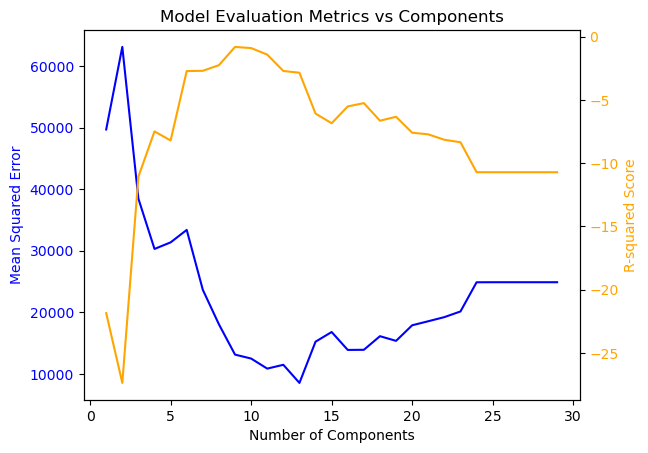

In [7]:
fig, ax1 = plt.subplots()

# Plot Mean Squared Error on the primary y-axis
ax1.plot(components, mse_scores, label='MSE', color='blue')
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("Mean Squared Error", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for R-squared scores
ax2 = ax1.twinx()
ax2.plot(components, r_squared_scores, label='R²', color='orange')
ax2.set_ylabel("R-squared Score", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Model Evaluation Metrics vs Components")
plt.show()

As stated, the scores are not in the ranges expected so we will have to come back to the reasoning behind this. Meanwhile, we will come back to implementing cross validation for parameter selection. We can use GridSearchCV for this and both MSE and $R^2$ scorers have been assessed, using 5-fold CV.

In [8]:
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
param_grid = {'n_components': components}
pls = PLSRegression()

# CV with MSE
grid_search = GridSearchCV(pls, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1) # n_jobs for parallelization
grid_search.fit(train_x, train_y)
best_n_components_grid = grid_search.best_params_['n_components']
print(f"Best n_components (GridSearchCV, MSE): {best_n_components_grid}")

# CV with R2
grid_search = GridSearchCV(pls, param_grid, cv=kf, scoring='r2', n_jobs=-1) # n_jobs for parallelization
grid_search.fit(train_x, train_y)
best_n_components_grid = grid_search.best_params_['n_components']
print(f"Best n_components (GridSearchCV, R2): {best_n_components_grid}")

# CV with RMSE
gid_search = GridSearchCV(pls, param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1) # n_jobs for parallelization
grid_search.fit(train_x, train_y)
best_n_components_grid = grid_search.best_params_['n_components']
print(f"Best n_components (GridSearchCV, RMSE): {best_n_components_grid}")

Best n_components (GridSearchCV, MSE): 7
Best n_components (GridSearchCV, R2): 7
Best n_components (GridSearchCV, RMSE): 7


All scoring parameters agree. The following shows a plot of the results across n_components.

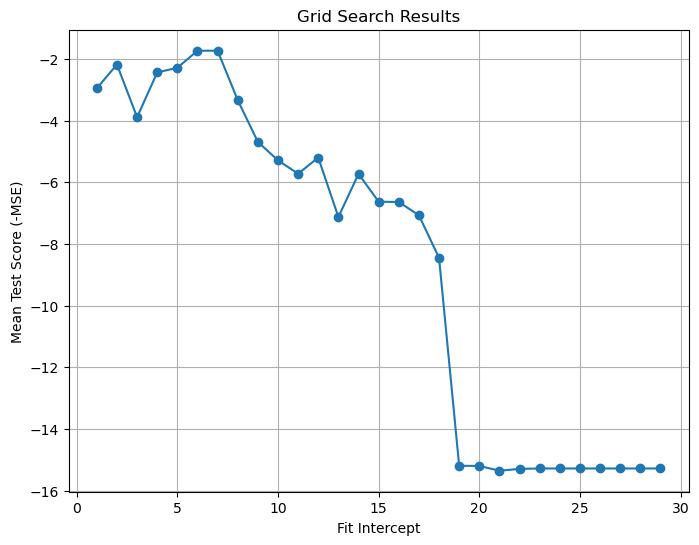

In [9]:
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
plt.plot([d["n_components"] for d in results_df["params"]], results_df["mean_test_score"],
         marker="o")
plt.xlabel("Fit Intercept")  # X-axis label
plt.ylabel(f"Mean Test Score (-MSE)")  # Y-axis label (Note: negative MSE)
plt.title("Grid Search Results")
plt.grid(True)
plt.show()